In [1]:
from IPython.core.display import display, HTML
from IPython.core.display import Image as ImageIpy
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import matplotlib
%matplotlib notebook

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
from pprint import pprint, pformat
import skimage
import skimage.io

from matplotlib import pyplot as plt
from PIL import Image
from resizeimage import resizeimage
import pickle

## Consolidated Functions

In [4]:
def get_project_directory(_1, _2, subset):
    mscoco_dir = '/media/nitred/mydata/datasets/mscoco/2017'
    return os.path.join(mscoco_dir, subset)

In [41]:
def read_json_file(json_path):
    """Function to read json file."""
    with open(json_path, 'r') as f:
        json_obj = json.loads(f.read())
    return json_obj


def get_ignore_ids(ignore_ids_path):
    """."""
    print("Get Ignore Ids", ignore_ids_path)
    if os.path.isfile(ignore_ids_path):
        # Read
        with open(ignore_ids_path, 'rb') as f:
            ignore_ids = pickle.load(f)

        # Corner case
        if not isinstance(ignore_ids, list):
            ignore_ids = []
    else:
        ignore_ids = []

    print("Ignore Ids: {}".format(len(ignore_ids)))
    return ignore_ids


def update_ignore_ids(ignore_ids_path, ignore_ids):
    """."""
    print("Updating Ignore Ids", ignore_ids_path)
    if os.path.isfile(ignore_ids_path):
        # Read
        with open(ignore_ids_path, 'rb') as f:
            orig_ignore_ids = pickle.load(f)
            print("Original Ignore Ids: {}".format(len(orig_ignore_ids)))

        # Update
        if isinstance(orig_ignore_ids, list):
            new_ignore_ids = orig_ignore_ids + ignore_ids
        else:
            # Corner case
            new_ignore_ids = ignore_ids
    else:
        # Update
        new_ignore_ids = ignore_ids

    # Write
    with open(ignore_ids_path, 'wb') as f:
        pickle.dump(new_ignore_ids, f)
        print("New Ignore Ids: {}".format(len(new_ignore_ids)))


def get_image_id_to_image_caption_category_dict_from_sub_dir(sub_dir):
    """Return dict object mapping image id to image details."""
    images_dir = os.path.join(sub_dir, 'images')
    captions_json_path = os.path.join(sub_dir, 'captions.json')
    stuff_json_path = os.path.join(sub_dir, 'stuff.json')
    ignore_ids_path = os.path.join(sub_dir, 'ignore_ids.pkl')

    captions_json = read_json_file(captions_json_path)
    stuff_json = read_json_file(stuff_json_path)

    # Get Image Dict from captions json
    images_dict = {image['id']: image for image in captions_json['images']}

    # Update Image Dict:
    for key in images_dict.keys():
        # Update with empty captions list
        images_dict[key]['captions'] = []
        # Update with empty category list
        images_dict[key]['categories'] = []
        # Full path to image
        images_dict[key]['path'] = os.path.join(images_dir, images_dict[key]['file_name'])
        images_dict[key]['path_128'] = os.path.join(images_dir, "128_" + images_dict[key]['file_name'])
        images_dict[key]['path_224'] = os.path.join(images_dir, "224_" + images_dict[key]['file_name'])

    # Update Image Dict:
    for anno in captions_json['annotations']:
        # Update the captions list from annotations
        images_dict[anno['image_id']]['captions'].append(anno['caption'])

    # Update Image Dict with categories
    # images_dict['categories'] = stuff_json['categories']

    # Update Image Dict:
    for stuff_anno in stuff_json['annotations']:
        # Update the categories list from stuff-annotations
        images_dict[stuff_anno['image_id']]['categories'].append(stuff_anno['category_id'])

    # Create Categories Dict:
    categories_dict = {stuff_cat['id']: stuff_cat for stuff_cat in stuff_json['categories']}

#     # Update Categories Dict:
#     sorted_categories_ids = sorted(categories_dict.keys())
#     sorted_categories_dict = {}
#     for sorted_id, category_id in enumerate(sorted_categories_ids):
#         sorted_categories_dict[sorted_id] = categories_dict[category_id]
#         sorted_categories_dict[sorted_id]['sorted_id'] = sorted_id

    # Remove ignore ids
    ignore_ids = get_ignore_ids(ignore_ids_path)
    for ignore_id in ignore_ids:
        images_dict.pop(ignore_id, None)

    return images_dict, categories_dict


def generate_square_images(subset, images_dict, pixels):
    """."""
    ignore_ids = np.empty(shape=[len(images_dict.keys())], dtype=int)
    ignore_index = 0
    for i, key in enumerate(images_dict.keys()):
        image_dict = images_dict[key]
        try:
            pass
            with open(image_dict['path'], 'r+b') as f:
                with Image.open(f) as image:
                    cover = resizeimage.resize_cover(image, [pixels, pixels, 3])
                    cover.save(image_dict['path_{}'.format(pixels)], image.format)
        except resizeimage.ImageSizeError:
            # print("{},".format(image_dict['id']))
            ignore_ids[ignore_index] = image_dict['id']
            ignore_index += 1
        except FileNotFoundError:
            # print("{},".format(image_dict['id']))
            ignore_ids[ignore_index] = image_dict['id']
            ignore_index += 1

        if i % 1000 == 0:
            print("Iter: {}, Ignored: {}".format(i, ignore_index))

    ignore_ids = list(ignore_ids[:ignore_index])

    if ignore_ids:
        subset_dir = get_project_directory('mscoco', 'dataset', subset)
        ignore_ids_path = os.path.join(subset_dir, 'ignore_ids.pkl')
        update_ignore_ids(ignore_ids_path, ignore_ids)


def get_images_and_categories_dict(subset):
    """.

    Args:
        subset (str): 'train' or 'test' or 'val'.
    """
    mscoco_sub_dir = get_project_directory('mscoco', 'dataset', subset)
    images_dict, categories_dict = get_image_id_to_image_caption_category_dict_from_sub_dir(mscoco_sub_dir)

    return images_dict, categories_dict


def get_n_random_categories(categories_dict, n_categories):
    """Return random ."""
    np.random.seed(seed=11111)
    random_slice = list(np.random.permutation(len(categories_dict.keys()))[:n_categories])
    random_n_categories = list(np.array(sorted(categories_dict.keys()))[random_slice])
    return random_n_categories


def get_filtered_image_dict_from_categories(images_dict, categories):
    """."""
    categories = sorted(categories)
    filtered_images_dict = {}

    for key in images_dict.keys():
        image_dict = images_dict[key]
        # Get one intersection
        intersection_category = sorted(set(categories).intersection(set(image_dict['categories'])))[:1]
        if intersection_category:
            intersection_category = intersection_category[0]
            filtered_images_dict[key] = image_dict
            filtered_images_dict[key]['chosen_category_id'] = intersection_category
            # Label is the index of the category in the list of categories
            chosen_category_label = categories.index(intersection_category)
            filtered_images_dict[key]['chosen_category_label'] = chosen_category_label

    return filtered_images_dict


def get_filtered_mage_dict_for_subset_for_n_categories(subset, n_categories=10, categories=[]):
    """."""
    images_dict, categories_dict = get_images_and_categories_dict(subset)
    if not categories:
        print("Filtering using n_categories: {}".format(n_categories))
        random_n_categories = get_n_random_categories(categories_dict, n_categories)
    else:
        print("Filtering using categories  : {}".format(len(categories)))
        random_n_categories = categories
    filtered_images_dict = get_filtered_image_dict_from_categories(images_dict, random_n_categories)
    return filtered_images_dict, categories_dict


def load_image(path):
    """."""
    # load image
    img = skimage.io.imread(path)
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    # short_edge = min(img.shape[:2])
    # yy = int((img.shape[0] - short_edge) / 2)
    # xx = int((img.shape[1] - short_edge) / 2)
    # crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # # resize to 224, 224
    # resized_img = skimage.transform.resize(crop_img, (224, 224))
    return img


def add_faulty_images_to_ignore(subset):
    """."""
    images_dict, categories_dict = get_images_and_categories_dict(subset)
    subset_dir = get_project_directory('mscoco', 'dataset', subset)
    ignore_ids_path = os.path.join(subset_dir, "ignore_ids.pkl")
    ignore_ids_ndim = []
    ignore_ids_exception = []
    for i, key in enumerate(images_dict.keys()):
        image_dict = images_dict[key]
        try:
            img = load_image(image_dict['path_224'])
            if not img.ndim == 3:
                ignore_ids_ndim.append(image_dict['id'])
        except Exception as ex:
            ignore_ids_exception.append(image_dict['id'])

        if i % 1000 == 0:
            print("Iter: {}, Ignored: {}".format(i, len(ignore_ids_ndim + ignore_ids_exception)))

    ignore_ids = ignore_ids_ndim + ignore_ids_exception
    if ignore_ids:
        update_ignore_ids(ignore_ids_path, ignore_ids)


def one_hot_encoding(arr, n_categories):
    """."""
    n_rows = len(arr)
    one_hot = np.zeros(shape=[n_rows, n_categories], dtype=int)
    # Magic.
    one_hot[np.arange(n_rows), arr.astype(int)] = 1
    return one_hot


class mscoco_generator(object):
    """."""

    def __init__(self, subset='val', n_categories=10, categories=[], batch_size=32):
        """."""
        self.subset = subset
        self.n_categories = n_categories
        self.batch_size = batch_size
        self.categories = sorted(categories)

        if self.categories:
            self.n_categories = len(self.categories)

        self.images_dict, self.categories_dict = get_filtered_mage_dict_for_subset_for_n_categories(self.subset,
                                                                                                    self.n_categories,
                                                                                                    self.categories)

        self.batch_generator = self.__generate_batches()

    def __generate_batches(self):
        """."""
        start_index = 0
        images_keys = np.array(sorted(self.images_dict.keys()))

        # shuffle deterministically
        if self.subset == 'val':
            np.random.seed(seed=11111)
        elif self.subset == 'train':
            np.random.seed(seed=22222)
        else:
            np.random.seed(seed=33333)
        np.random.shuffle(images_keys)

        while True:
            batch_indices = range(start_index, start_index + self.batch_size, 1)
            batch_keys = images_keys.take(batch_indices, mode='wrap')
            start_index += self.batch_size

            batch_x = np.empty([self.batch_size, 224, 224, 3])
            batch_y = np.empty([self.batch_size, 1])

            # Load batch
            for i, image_key in enumerate(batch_keys):
                batch_x[i] = load_image(self.images_dict[image_key]['path_224'])
                batch_y[i] = float(self.images_dict[image_key]['chosen_category_label'])

            batch_y_one_hot = one_hot_encoding(batch_y.ravel(), self.n_categories)

            # Yield batch
            yield batch_x, batch_y_one_hot

    def next_batch(self):
        """."""
        return next(self.batch_generator)
    
    def test_batch(self, batch_size):
        """."""
        temp_batch_size = self.batch_size
        self.batch_size = batch_size
        self.reset_generator()
        test_batch = self.next_batch()
        self.batch_size = temp_batch_size
        self.reset_generator()
        return test_batch
        
    def reset_generator(self):
        """."""
        self.batch_generator = self.__generate_batches()

    def get_category_mapping(self):
        """."""
        category_labels = list(range(self.n_categories))
        category_names = []
        for category_label in category_labels:
            for key in self.images_dict.keys():
                if category_label == self.images_dict[key]['chosen_category_label']:
                    category_id = self.images_dict[key]['chosen_category_id']
                    category_name = self.categories_dict[category_id]['name']
                    super_category_name = self.categories_dict[category_id]['supercategory']
                    category_names.append([category_label, category_id, category_name, super_category_name])
                    break
        return category_names

    def get_category_ids(self):
        """."""
        category_labels = list(range(self.n_categories))
        category_ids = []
        for category_label in category_labels:
            for key in self.images_dict.keys():
                if category_label == self.images_dict[key]['chosen_category_label']:
                    category_id = self.images_dict[key]['chosen_category_id']
                    category_ids.append(category_id)
                    break
        return sorted(category_ids)

## Consolidated Globals

## Development

#### Val

In [54]:
images_dict, categories_dict = get_images_and_categories_dict('val')

Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/val/ignore_ids.pkl
Ignore Ids: 12


In [60]:
images_dict[37777]

{'captions': ['The dining table near the kitchen has a bowl of fruit on it.',
  'A small kitchen has various appliances and a table.',
  'The kitchen is clean and ready for us to see.',
  'A kitchen and dining area decorated in white.',
  'A kitchen that has a bowl of fruit on the table.'],
 'categories': [98,
  100,
  102,
  112,
  114,
  123,
  130,
  143,
  165,
  172,
  176,
  181,
  183],
 'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg',
 'date_captured': '2013-11-14 20:55:31',
 'file_name': '000000037777.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg',
 'height': 230,
 'id': 37777,
 'license': 1,
 'path': '/media/nitred/mydata/datasets/mscoco/2017/val/images/000000037777.jpg',
 'path_128': '/media/nitred/mydata/datasets/mscoco/2017/val/images/128_000000037777.jpg',
 'path_224': '/media/nitred/mydata/datasets/mscoco/2017/val/images/224_000000037777.jpg',
 'width': 352}

In [55]:
categories_dict

{92: {'id': 92, 'name': 'banner', 'supercategory': 'textile'},
 93: {'id': 93, 'name': 'blanket', 'supercategory': 'textile'},
 94: {'id': 94, 'name': 'branch', 'supercategory': 'plant'},
 95: {'id': 95, 'name': 'bridge', 'supercategory': 'building'},
 96: {'id': 96, 'name': 'building-other', 'supercategory': 'building'},
 97: {'id': 97, 'name': 'bush', 'supercategory': 'plant'},
 98: {'id': 98, 'name': 'cabinet', 'supercategory': 'furniture-stuff'},
 99: {'id': 99, 'name': 'cage', 'supercategory': 'structural'},
 100: {'id': 100, 'name': 'cardboard', 'supercategory': 'raw-material'},
 101: {'id': 101, 'name': 'carpet', 'supercategory': 'floor'},
 102: {'id': 102, 'name': 'ceiling-other', 'supercategory': 'ceiling'},
 103: {'id': 103, 'name': 'ceiling-tile', 'supercategory': 'ceiling'},
 104: {'id': 104, 'name': 'cloth', 'supercategory': 'textile'},
 105: {'id': 105, 'name': 'clothes', 'supercategory': 'textile'},
 106: {'id': 106, 'name': 'clouds', 'supercategory': 'sky'},
 107: {'id'

In [37]:
len(images_dict.keys())

4998

In [8]:
images_dict, categories_dict = get_images_and_categories_dict('val')
print(len(images_dict))
# generate_square_images('val', images_dict, pixels=224)
add_faulty_images_to_ignore('val')

Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/val/ignore_ids.pkl
Ignore Ids: 12
4988
Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/val/ignore_ids.pkl
Ignore Ids: 12
Iter: 0, Ignored: 0
Iter: 1000, Ignored: 0
Iter: 2000, Ignored: 0
Iter: 3000, Ignored: 0
Iter: 4000, Ignored: 0


#### Manual Manipulation
```
Manually Created the following to 224x224

/media/nitred/mydata/datasets/mscoco/2017/val/images/000000456394.jpg
/media/nitred/mydata/datasets/mscoco/2017/val/images/000000149770.jpg
```

#### Train

In [7]:
images_dict, categories_dict = get_images_and_categories_dict('train')
print(len(images_dict))
# generate_square_images('train', images_dict, pixels=224)
# add_faulty_images_to_ignore('train')

Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/train/ignore_ids.pkl
Ignore Ids: 11727
106560


#### Test

In [ ]:
# images_dict, categories_dict = get_images_and_categories_dict('test')
# generate_square_images(images_dict, pixels=224)

In [42]:
val_dataset = mscoco_generator(subset='val',
                                            n_categories=10,
                                            batch_size=2)
train_dataset = mscoco_generator(subset='train',
                                              categories=val_dataset.get_category_ids(),
                                              batch_size=2)

Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/val/ignore_ids.pkl
Ignore Ids: 12
Filtering using n_categories: 10
Get Ignore Ids /media/nitred/mydata/datasets/mscoco/2017/train/ignore_ids.pkl
Ignore Ids: 11727
Filtering using categories  : 10


<IPython.core.display.Javascript object>


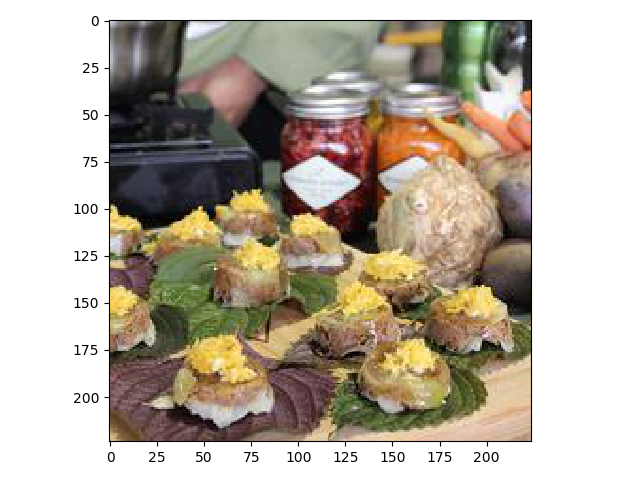

<IPython.core.display.Javascript object>


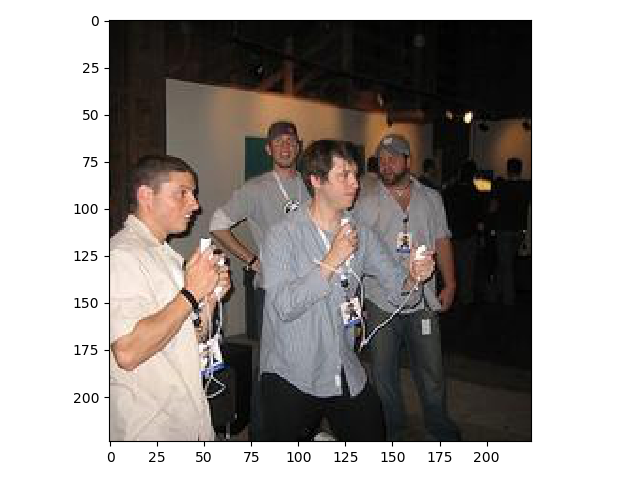

In [57]:
bx, by = train_dataset.next_batch()
for x in bx:
    plt.figure()
    skimage.io.imshow(x)

In [58]:
by

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
train_dataset.get_category_mapping()

[[0, 106, 'clouds', 'sky'],
 [1, 113, 'fence', 'structural'],
 [2, 115, 'floor-other', 'floor'],
 [3, 119, 'flower', 'plant'],
 [4, 148, 'river', 'water'],
 [5, 158, 'skyscraper', 'building'],
 [6, 160, 'solid-other', 'solid'],
 [7, 164, 'structural-other', 'structural'],
 [8, 170, 'vegetable', 'food-stuff'],
 [9, 176, 'wall-tile', 'wall']]

In [53]:
bx, by = val_dataset.test_batch(2)
by
# for x in bx:
#     plt.figure()
#     skimage.io.imshow(x)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [38]:
val_dataset.get_category_mapping()

[[0, 106, 'clouds', 'sky'],
 [1, 113, 'fence', 'structural'],
 [2, 115, 'floor-other', 'floor'],
 [3, 119, 'flower', 'plant'],
 [4, 148, 'river', 'water'],
 [5, 158, 'skyscraper', 'building'],
 [6, 160, 'solid-other', 'solid'],
 [7, 164, 'structural-other', 'structural'],
 [8, 170, 'vegetable', 'food-stuff'],
 [9, 176, 'wall-tile', 'wall']]